In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import os
import re
import numpy as np
import pickle

from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator

In [5]:
def load_timeseries(fname):
    ts = pd.read_csv(f'data/{fname}')
    ts['Date'] = pd.to_datetime(ts['Date'])

    return ts

def interpolate_cubicspline(ts, *, step_size='ME'):
    ''' 
    This function will perform a cubic spline interpolation on a given timeseries dataframe
    and, optionally, given a new-stepsize.
    e.g. 'D' for daily, 'ME' for monthly, ...
    The default (if not specified) new-stepsize is monthly ('ME')
    '''

    # Create the smaller dates for interpolation
    interp_dates = pd.date_range(start=ts['Date'].min(), end=ts['Date'].max(), freq=step_size)

    # Create a method for performign the cubic spline
    cs = CubicSpline(pd.to_datetime(ts['Date']), ts['Average City MPG'])

    # Perform the cubic spline interpolation
    interp_values = cs(interp_dates)

    interp_ts = pd.DataFrame({'Date': interp_dates, 'Average City MPG': interp_values})

    return interp_ts

def interpolate_akima1d(ts, *, step_size='ME'):
    ''' 
    This function will perform an Akima1d interpolation on a given timeseries dataframe
    and, optionally, given a new-stepsize.
    e.g. 'D' for daily, 'ME' for monthly, ...
    The default (if not specified) new-stepsize is monthly ('ME')

    Why use Akima1d instead of cubic spline? Well cubic splines can sometimes 'overfit' or 'over-oscillate' 
    So Akima1d can be smoother

    '''

    # Create the smaller dates for interpolation
    interp_dates = pd.date_range(start=ts['Date'].min(), end=ts['Date'].max(), freq=step_size)

    # Create a method for performign the cubic spline
    cs = Akima1DInterpolator(pd.to_datetime(ts['Date']), ts['Average City MPG'])

    # Perform the cubic spline interpolation
    interp_values = cs(interp_dates)

    interp_ts = pd.DataFrame({'Date': interp_dates, 'Average City MPG': interp_values})

    return interp_ts


def interpolate_pchip(ts, *, step_size='ME'):
    ''' 
    This function will perform an PCHIP interpolation on a given timeseries dataframe
    and, optionally, given a new-stepsize.
    e.g. 'D' for daily, 'ME' for monthly, ...
    The default (if not specified) new-stepsize is monthly ('ME')

    Why use PCHIP instead of cubic spline? Well cubic splines can sometimes 'overfit' or 'over-oscillate' 
    So PCHIP can be smoother, similar to Akima1d

    '''

    # Create the smaller dates for interpolation
    interp_dates = pd.date_range(start=ts['Date'].min(), end=ts['Date'].max(), freq=step_size)

    # Create a method for performign the cubic spline
    cs = PchipInterpolator(pd.to_datetime(ts['Date']), ts['Average City MPG'])

    # Perform the cubic spline interpolation
    interp_values = cs(interp_dates)

    interp_ts = pd.DataFrame({'Date': interp_dates, 'Average City MPG': interp_values})

    return interp_ts
    

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

def forecast_test(ts, *, train_size=0.8, seasonal=False, m=1, information_criterion='aic'):
    # Split data into 80/20 train/test 
    train_size = int(len(ts) * train_size)
    train_ts, test_ts = ts[:train_size], ts[train_size:]

    model_ = auto_arima(train_ts['Average City MPG'], trace=True, seasonal = seasonal, m = m, information_criterion=information_criterion)

    # Given a number of forecast steps, make predictions
    forecast_steps = len(test_ts)
    forecast_values, conf_int = model_.predict(n_periods=forecast_steps, return_conf_int=True)
    forecast_values

    # Create Dates for the predictions
    step_size = pd.infer_freq(ts['Date']) #'y'
    forecast_dates = pd.date_range(start=test_ts.iloc[0,0], periods=forecast_steps, freq=step_size)

    # Place into a dataframe
    forecast_ts = pd.DataFrame({'Date': forecast_dates, 'Average City MPG': forecast_values})

    # Append the last time date of the training set to the test and forecast set. 
    # This helps with plotting 
    test_ts = pd.concat([train_ts.iloc[[-1]], test_ts])
    forecast_ts = pd.concat([train_ts.iloc[[-1]], forecast_ts])

    return model_, train_ts, test_ts, forecast_ts


#### Use Auto Arima to Find Model on Interpolated Data

Run Auto Arima...
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : BIC=-1710.459, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=-416.225, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=-1302.597, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=-723.827, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=-415.538, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : BIC=-1723.047, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : BIC=-1715.475, Time=0.13 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : BIC=-1714.006, Time=1.35 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : BIC=-1716.089, Time=0.36 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : BIC=-1708.205, Time=1.24 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : BIC=-1512.484, Time=0.40 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : BIC=-1309.248, Time=0.51 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : BIC=-1710.388, Time=0.40 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : BIC=-1716.289, Time

Text(0.5, 1.0, 'Prediction on Interpolated Time Series')

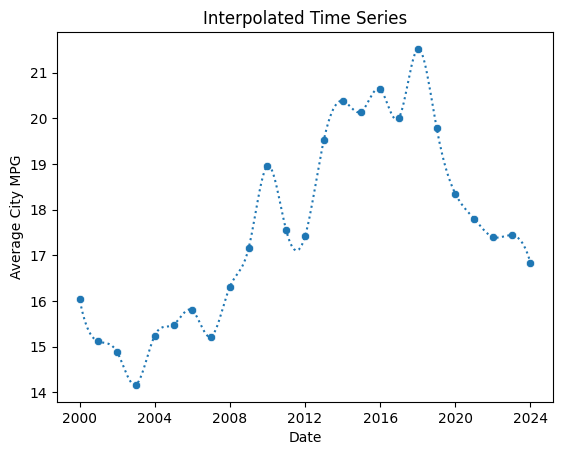

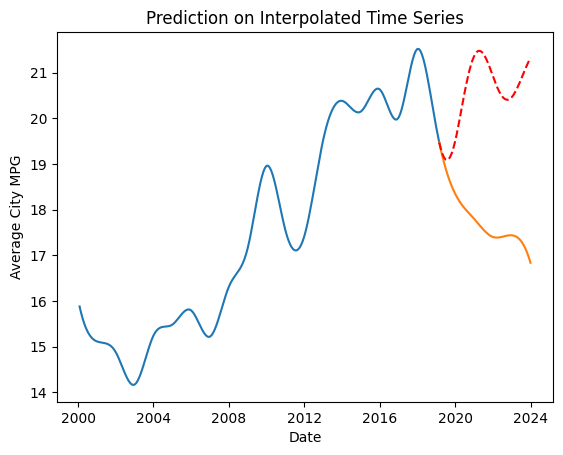

In [6]:
#fname = 'sorted_electric_ford.csv' 
#fname = 'sorted_electric_hyundai.csv'
fname = 'sorted_gasoline_chevrolet.csv'
interpolate_step = 'ME' # Interpolate the data with a new frequency
# D - daily
# ME - end of month, 
# QE - end of quarter, etc.

# Load the file form the csv
orig_df = load_timeseries(fname)
# Interpolate the time series via the step size given by interpolate_step
# D - daily
# ME - end of month, etc.
df = interpolate_cubicspline(orig_df, step_size=interpolate_step) #<--- Trying cubic spline interpolation
#df = interpolate_akima1d(orig_df, step_size=interpolate_step) #<--- Trying Akima 1D interpolation
#df = interpolate_pchip(orig_df, step_size=interpolate_step) #<--- Trying Pchip interpolatoin

# Plot original time series and interpolated time series
f1, ax1 = plt.subplots()
sns.scatterplot(data=orig_df, x='Date', y='Average City MPG', ax=ax1)
sns.lineplot(data=df, x='Date', y='Average City MPG', ls=':', ax=ax1)
ax1.set_title('Interpolated Time Series')

print('Run Auto Arima...')
############################# Run Auto ARIMA #############################################
seasonal = True # Is there some seasonality to the data (set to False if not)
m = 12 # If there is seasonality, how many datapoints are in a year? If data is daily, 365; if data is monthly, 12; if data is quarterly, 4; etc.
# If there is no seasonality, then set m to 1!
train_size = 0.8

# Scoring to pick the best model
information_criterion = 'bic'
# ‘aic’, ‘bic’, ‘hqic’, ‘oob’

ts = df
model, train_ts, test_ts, forecast_ts = forecast_test(ts, train_size=train_size, seasonal=seasonal, m=m, information_criterion=information_criterion)

f2, ax2 = plt.subplots(1)
sns.lineplot(data=train_ts, x='Date', y='Average City MPG', ax=ax2)
sns.lineplot(data=test_ts, x='Date', y='Average City MPG', ax=ax2)
sns.lineplot(data=forecast_ts, x='Date', y='Average City MPG', c='r', ls='--', ax=ax2)
ax2.set_title('Prediction on Interpolated Time Series')



#### Make a long term prediction using model from above

In [7]:
def forecast(model, ts, forecast_steps, *, train_size=0.8, seasonal=False, m=1, information_criterion='aic'):
    
    # Given a number of forecast steps, make predictions
    forecast_steps = len(ts)
    forecast_values, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)

    # Create Dates for the predictions
    step_size = pd.infer_freq(ts['Date']) 
    forecast_dates = pd.date_range(start=train_ts.iloc[-1,0], periods=forecast_steps, freq=step_size)

    # Place into a dataframe
    forecast_ts = pd.DataFrame({'Date': forecast_dates, 'Average City MPG': forecast_values})

    # Append the last time date of the training set to the test and forecast set. 
    # This helps with plotting 
    #forecast_ts = pd.concat([train_ts.iloc[[-1]], forecast_ts])

    return forecast_ts

<Axes: xlabel='Date', ylabel='Average City MPG'>

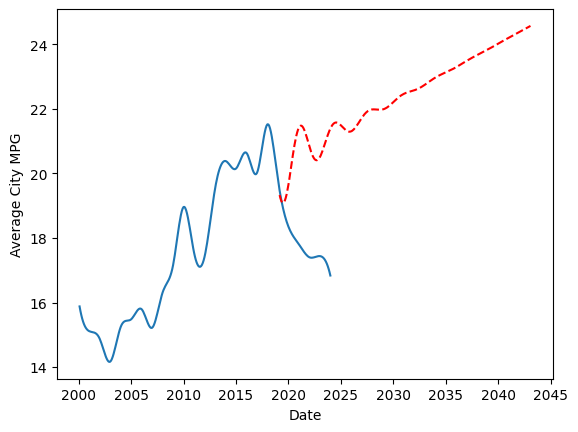

In [8]:
prediction_ts = forecast(model, ts, 100)
f3, ax3 = plt.subplots()
sns.lineplot(data=ts, x='Date', y='Average City MPG', ax=ax3)
sns.lineplot(data=prediction_ts, x='Date', y='Average City MPG', c='r', ls='--', ax=ax3)
